**The Problem Statement**

The dataset consists of the attributes of users who visit a particular shopping rate. The goal is identify the 'conversion rate' of the website: Predict how likely the site is to turn visitors into buyers.

In [2]:
#import libraries

%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno 

import warnings
warnings.simplefilter('ignore')

In [19]:
from sklearn.utils import resample

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from sklearn.metrics import roc_curve,roc_auc_score, auc
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve

from collections import OrderedDict

## Load and Basic Exploratory Data Analysis

In [3]:
df = pd.read_csv('conversion_data.csv')

In [4]:
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


### Missing Values

In [5]:
#Check Missing Values

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              316200 non-null  object
 1   age                  316200 non-null  int64 
 2   new_user             316200 non-null  int64 
 3   source               316200 non-null  object
 4   total_pages_visited  316200 non-null  int64 
 5   converted            316200 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


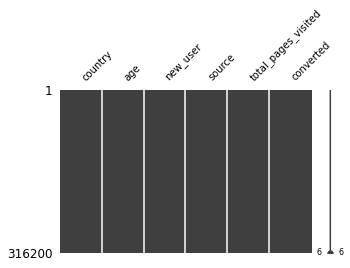

In [6]:
#Check using missingno too
missingno.matrix(df, figsize=(5,3), fontsize = 10)

No missing values in the dataset

### Outliers

In [10]:
df.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


Age looks fishy: the mean age is 31 years, but the maximum age is 123. Also, the mean of converted indicates that it is **highly skewed**

In [7]:
for column in df.columns:
    uniques = sorted(df[column].unique())
    print('{0:20s} {1:5d}\t'.format(column, len(uniques)), uniques[:5])

country                  4	 ['China', 'Germany', 'UK', 'US']
age                     60	 [17, 18, 19, 20, 21]
new_user                 2	 [0, 1]
source                   3	 ['Ads', 'Direct', 'Seo']
total_pages_visited     29	 [1, 2, 3, 4, 5]
converted                2	 [0, 1]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11d0ee7f0>,
      dtype=object)

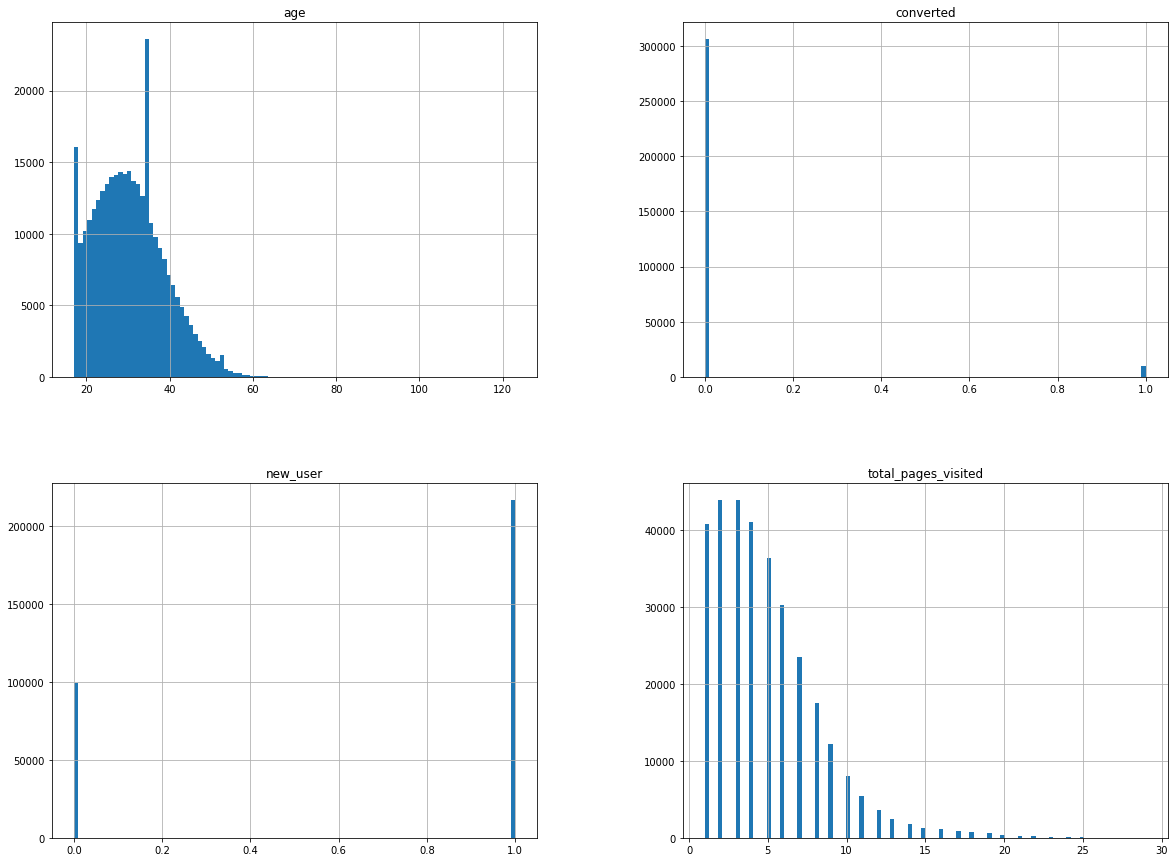

In [8]:
df.hist(bins = 100, figsize = (20,15))

In [9]:
## lets see the count of age
df.groupby('age')['age'].count()

age
17      7597
18      8466
19      9349
20     10156
21     10966
22     11701
23     12336
24     12960
25     13460
26     13931
27     14084
28     14341
29     14158
30     14346
31     13692
32     13507
33     12631
34     12108
35     11471
36     10779
37      9761
38      8970
39      8202
40      7148
41      6401
42      5588
43      4904
44      4224
45      3634
46      2994
47      2504
48      2121
49      1629
50      1356
51      1093
52       935
53       627
54       520
55       394
56       286
57       247
58       165
59       127
60        94
61        71
62        59
63        35
64        27
65        15
66         9
67         5
68         5
69         3
70         2
72         1
73         1
77         1
79         1
111        1
123        1
Name: age, dtype: int64

In [10]:
#removing the entries for age >100
df = df[df['age'] <100]
df.describe()

,age,new_user,total_pages_visited,converted
count,316198.000000,316198.000000,316198.000000,316198.000000
mean,30.569311,0.685469,4.872918,0.032252
std,8.268958,0.464329,3.341053,0.176669
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,79.000000,1.000000,29.000000,1.000000


Much Better!

### Correlation Test

In [11]:
#Lets see if there are any correlated data values

corrMat = df.corr()
corrMat

,age,new_user,total_pages_visited,converted
age,1.000000,0.012445,-0.046093,-0.089199
new_user,0.012445,1.000000,-0.082522,-0.152338
total_pages_visited,-0.046093,-0.082522,1.000000,0.528975
converted,-0.089199,-0.152338,0.528975,1.000000


No significant correlation obsereved

### Exploratory Data Analysis

Number of people who bought something: 10198
Number of people who bought something: 306000
96.77480565974484  % people who visited the site did not buy anything


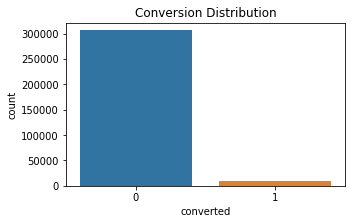

In [12]:
#Conversion

plt.subplots(1,1,figsize =(5,3))
sns.countplot(df['converted'])
plt.title('Conversion Distribution')

#Analysing the numbers
lenConv = len(df[df['converted']==1]['converted'])
lenNonConv = len(df[df['converted']==0]['converted'])
NonConvPerc = (lenNonConv / (lenNonConv + lenConv))*100
print('Number of people who bought something:', lenConv)
print('Number of people who bought something:', lenNonConv)
print(NonConvPerc, ' % people who visited the site did not buy anything')

Obviously, the dataset is extremely skewed, and using an accuracy based performance metric will not be appropriate

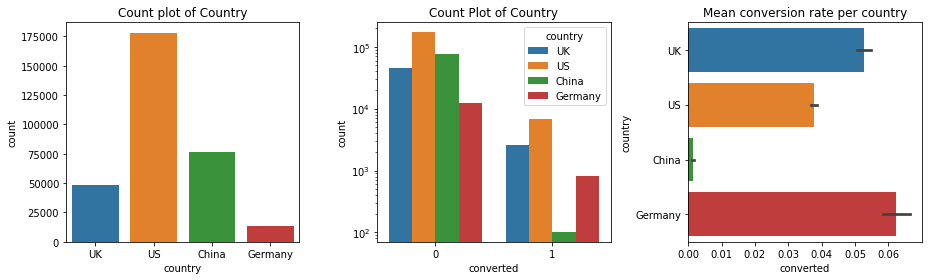

In [13]:
#Country

fig, ax = plt.subplots(1,3,figsize=(13,4))
sns.countplot(df['country'],ax=ax[0]);
ax[0].set_title('Count plot of Country',fontsize=12);
sns.countplot(df['converted'],hue=df['country'],ax=ax[1]);
ax[1].set_yscale('log')
ax[1].set_title('Count Plot of Country',fontsize=12)
sns.barplot(df['converted'],df['country'],ax=ax[2]);
ax[2].set_title('Mean conversion rate per country',fontsize=12);

plt.tight_layout()
plt.show()

 Takeaways:
   1. US has the highest website visits but not the highest conversion rate
   2. Germany has the fewest visits but the highest conversion rates
   3. China has the lowest conversion rate, even if it has the second largest number of website visits.

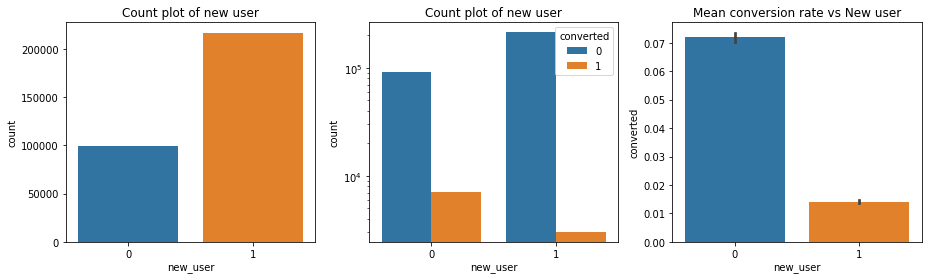

In [14]:
#New User

fig, ax = plt.subplots(1,3,figsize=(13,4))
sns.countplot(df['new_user'],ax=ax[0])
ax[0].set_title('Count plot of new user')
sns.countplot(df['new_user'],hue=df['converted'],ax=ax[1])
ax[1].set_yscale('log')
ax[1].set_title('Count plot of new user')
sns.barplot(x='new_user',y='converted',data=df,ax=ax[2])
ax[2].set_title('Mean conversion rate vs New user')
plt.tight_layout()
plt.show()

Takeaways:
   1. Old users are more likely to buy something (convert)
    

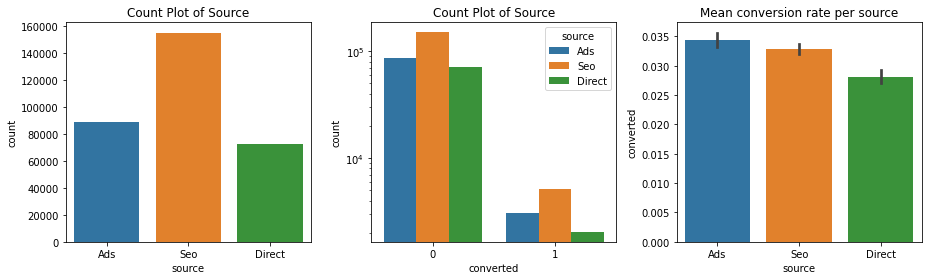

In [15]:
#Sources


fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(13,4))
sns.countplot(df['source'],ax=ax[0]);
ax[0].set_title('Count Plot of Source')
sns.countplot(df['converted'], hue=df['source'],data=df,ax=ax[1]);
ax[1].set_yscale('log')
ax[1].set_title('Count Plot of Source',fontsize=12);
sns.barplot(x='source',y='converted',data=df,ax=ax[2]);
ax[2].set_title('Mean conversion rate per source',fontsize=12);
plt.tight_layout()
plt.show()

Takeaways:
   1. Search results (Seo) is the most common way that causes visitors to visit the website
   2. Ads have the highest conversion rates
   3. Directly typing the URL brings the least amount of vistors, who are less likely to convert.

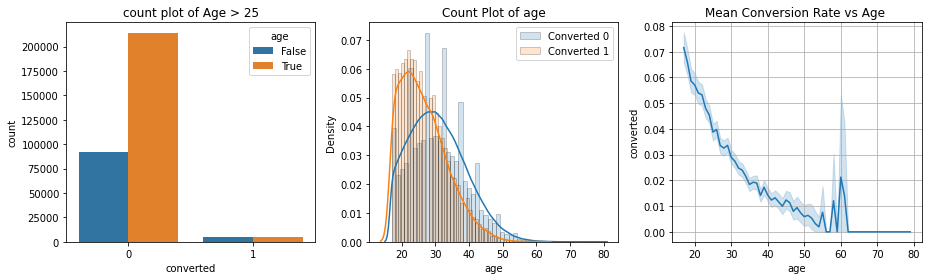

In [16]:
#Age

fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(13,4))
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}
sns.countplot(df['converted'],hue=df['age']>25,ax=ax[0])
ax[0].set_title('count plot of Age > 25')
con_0 = df[df['converted']==0]['age']
con_1 = df[df['converted']==1]['age']
sns.distplot(con_0,label='Converted 0', ax=ax[1],hist_kws=hist_kws)
sns.distplot(con_1,label='Converted 1', ax=ax[1],hist_kws=hist_kws)
ax[1].legend()
ax[1].set_title('Count Plot of age',fontsize=12);
sns.lineplot(x='age',y='converted',data=df,ax=ax[2]);
ax[2].set_title('Mean Conversion Rate vs Age ',fontsize=12);
ax[2].grid(True)
plt.tight_layout()
plt.show()

Takeaways:
    1. Older people tend to convert more
    2. For users below the age of 50, conversion rates decrease with age

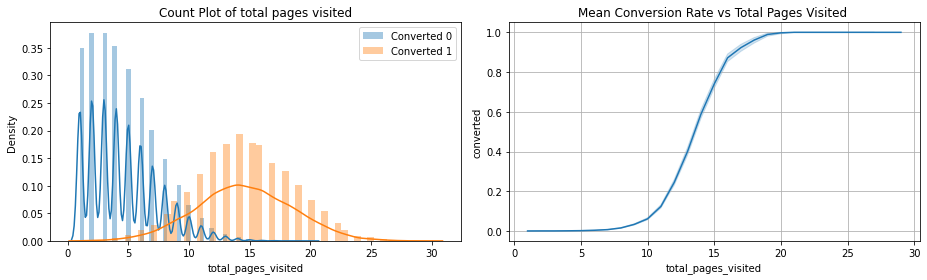

In [17]:
#Total Pages Visited


# Total pages visited variable visualization
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(13,4))
con_0 = df[df['converted']==0]['total_pages_visited']
con_1 = df[df['converted']==1]['total_pages_visited']
sns.distplot(con_0,label='Converted 0', ax=ax[0])
sns.distplot(con_1,label='Converted 1', ax=ax[0])
ax[0].legend()
ax[0].set_title('Count Plot of total pages visited',fontsize=12);
sns.lineplot(x='total_pages_visited',y='converted',data=df,ax=ax[1], markers=True, dashes=False);
ax[1].set_title('Mean Conversion Rate vs Total Pages Visited ',fontsize=12);
ax[1].grid(True)
plt.tight_layout()
plt.show()

Takeaways:
   1. Most people who convert visit 10 to 20 pages
   2. People who do not convert visit less than 15 pages

## Building the ML Model

In [23]:
#One hot encoding

data = df.copy()

data = pd.get_dummies(data, columns = ['country', 'source'], prefix = ['country','source'])

data = data.reset_index()

x = data[['age', 'new_user', 'total_pages_visited', 'country_China',
       'country_Germany', 'country_UK', 'country_US', 'source_Ads',
       'source_Direct', 'source_Seo']]
y = data['converted']

X_train, X_test, y_train, y_test = train_test_split(x,y, test_size = 0.3)

### Random Forest Classifier

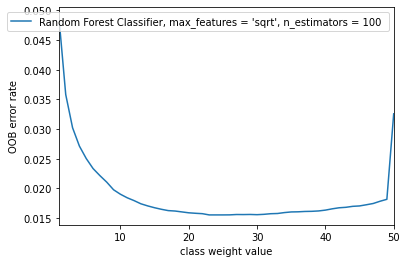

In [24]:
#Since the data set is unbalanced, we use the OOB score to train the parameter 'class_weights'

clfs = [
    ("Random Forest Classifier, max_features = 'sqrt', n_estimators = 100 ",
     RandomForestClassifier(n_estimators = 100, class_weight = 'balanced', oob_score = True, max_features ='sqrt', 
                           random_state = 123)
    )
]

#generate <N_Estimators, Error_Rate> pairs
error_rate = OrderedDict((label, []) for label, _ in clfs)

# Range of class weight values to explore. [0:(0.02~1),1:(0.98~0)]
min_value = 1
max_value = 50

for label, clf in clfs:
    for i in range(min_value, max_value + 1):
        clf.set_params(class_weight={0:i*0.02,1:(1-i*0.02)})
        clf.fit(X_train, y_train)

        # Record the OOB error for each value=i setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "class weight" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_value, max_value)
plt.xlabel("class weight value")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

In [25]:

#Create a Random Forest Classifier using parameters we just get
clf=RandomForestClassifier(n_estimators=100,oob_score=True,class_weight={0:0.48,1:0.51},max_features="sqrt",
                               random_state=123,max_depth=9)
#Train the model using the training sets
clf.fit(X_train,y_train)

#OOB score
clf.oob_score_

0.9858677678482682

### Performance Metrics

In [27]:
#ROC for training 

y_train_preds = clf.predict_proba(X_train)

fpr_train, tpr_train, thresholds = roc_curve(y_train, y_train_preds[:,1])
roc_auc = auc(fpr_train, tpr_train)

#ROC for testing 
y_pred = clf.predict_proba(X_test)
fpr_test, tpr_test, thresholds = roc_curve(y_test, y_pred[:,1])
roc_auc_test = auc(fpr_test, tpr_test)

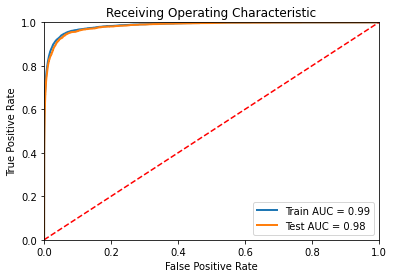

In [28]:
# Plot ROC curve and compare them
plt.plot(fpr_train, tpr_train,  linewidth=2, label='Train AUC = %0.2f'% roc_auc);
plt.plot(fpr_test, tpr_test, linewidth=2, label='Test AUC = %0.2f'% roc_auc_test)
plt.title("Receiving Operating Characteristic")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], 'r--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()


At both training and testing, the ROC-AUC is high. It makes sense that the TPR is high because of the imbalanced class (less positives than negatives)

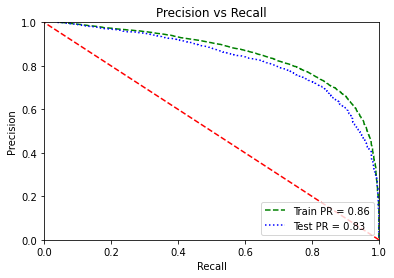

In [34]:
#precision and recall


precisions, recalls, thresholds = precision_recall_curve(y_train, y_train_preds[:,1] )
precisions_test, recalls_test, thresholds = precision_recall_curve(y_test, y_pred[:,1])
PR_train = auc(recalls,precisions)
PR_test = auc(recalls_test,precisions_test)
plt.plot(precisions,recalls,'g--',label='Train PR = %0.2f'% PR_train)
plt.plot(precisions_test,recalls_test,'b:',label='Test PR = %0.2f'% PR_test)
plt.legend(loc="lower right")
plt.plot([1, 0], [0, 1], 'r--')
plt.axis([0, 1, 0, 1])
plt.title('Precision vs Recall')
plt.ylabel('Precision')
plt.xlabel('Recall');

In [35]:
Y = []

for i in range (y_pred.shape[0]):
    if y_pred[i][0]> y_pred[i][1]:
        Y.append(0)
    else:
        Y.append(1)
print(classification_report(y_true = y_test, y_pred = Y))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     91867
           1       0.85      0.68      0.75      2993

    accuracy                           0.99     94860
   macro avg       0.92      0.84      0.87     94860
weighted avg       0.99      0.99      0.99     94860



In [36]:
print('Train set prediction accuracy is:',clf.score(X_train,y_train))
print('Test set prediction accuracy is:',clf.score(X_test,y_test))

Train set prediction accuracy is: 0.9867171475300219
Test set prediction accuracy is: 0.9860425890786422


In [37]:
#Lets see how the performance is compared to a model that simply predicts the majority class

baseline_preds = 0 # majority class not converted
# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_preds - y_test)
print('Average baseline prediction accuracy: ', (1-round(np.mean(baseline_errors), 4))*100,'%')

Average baseline prediction accuracy:  96.84 %


Our model performs better

### Feature Importance



In [38]:
feature_imp = pd.Series(clf.feature_importances_,
       index=X_train.columns).sort_values(ascending=False)
feature_imp

total_pages_visited    0.881567
new_user               0.045686
age                    0.034138
country_China          0.025195
country_UK             0.003512
country_US             0.003401
country_Germany        0.002292
source_Direct          0.001499
source_Ads             0.001380
source_Seo             0.001330
dtype: float64

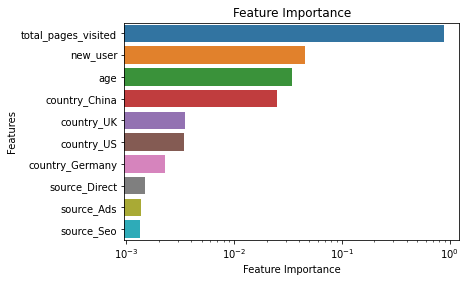

In [40]:
#Visualise

f = sns.barplot(x = feature_imp, y = feature_imp.index)
plt.xlabel('Feature Importance')
f.set_xscale('log')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()

Takeaways:
1. It makes sense that the total_pages_visited is the most important feature. We saw how converted customers tended to visit more pages than customers who did not convert.
2. Old users tend to buy more than new users
3. China has many visitors, but extremely less buyers. An analysis into China's market could help.
4. Advertisements, if targetted better, may cause an increase in conversions